## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help if you're stuck (please catch me in office hours, or right after class).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, happy to chat with you about your ideas anytime.

In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (181 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import random
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions to read slides and generate patches

In [4]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [5]:
def create_patches(category, slide, slide_idx, tumor_mask, image_idx, level, width = 299, height = 299, threshold_std = 5):
    '''
    category: str
        train, val, test
    slide: whole slide
    slide_idx: slide code; str
    tumor_mask: whole tumor mask
    image_idx: int
        saved patch path suffix
    level: int
        level num
    '''
    image_dir_normal = ''
    mask_dir_normal = ''
    image_dir_tumor = ''
    mask_dir_tumor = ''

    if category == 'train':
      image_dir_normal = train_image_dir_normal
      mask_dir_normal = train_mask_dir_normal
      image_dir_tumor = train_image_dir_tumor
      mask_dir_tumor = train_mask_dir_tumor
    elif category == 'val':
      image_dir_normal = val_image_dir_normal
      mask_dir_normal = val_mask_dir_normal
      image_dir_tumor = val_image_dir_tumor
      mask_dir_tumor = val_mask_dir_tumor
    else:
      image_dir_normal = test_image_dir_normal
      mask_dir_normal = test_mask_dir_normal
      image_dir_tumor = test_image_dir_tumor
      mask_dir_tumor = test_mask_dir_tumor     
    
    image_list = []
    mask_list = []
    labels = []
    xoffset = []
    yoffset = []
    downsample_factor = int(slide.level_downsamples[level])
    for x in range(0, slide.level_dimensions[level][0]-width, 128):
      for y in range(0, slide.level_dimensions[level][1]-height, 128):
        slide_region = read_slide(slide, x = x*downsample_factor, y = y*downsample_factor, level=level, width=width, height=height)
        mask_region = read_slide(tumor_mask, x = x*downsample_factor, y = y*downsample_factor, level=level, width=width, height=height)[:,:,0]
        center_x_min = center_y_min = 299//2-128//2
        center_x_max = center_y_max = 299//2+128//2
        check_region = mask_region[center_x_min:center_x_max,center_y_min:center_y_max]
        
        if np.mean(np.std(slide_region, axis=-1)) <= threshold_std:
          continue
        if check_region.max() == 0:
          labels.append(0)
          im = Image.fromarray(slide_region)
          im_name = f'slide{slide_idx}_{category}_image_normal_{image_idx}'
          path = os.path.join(image_dir_normal, im_name + '.jpeg')
          image_list.append(path)
          im.save(path)
          im = Image.fromarray(mask_region)
          im_name = f'slide{slide_idx}_{category}_mask_normal_{image_idx}'
          path = os.path.join(mask_dir_normal, im_name + '.jpeg')
          mask_list.append(path)
          im.save(path)
        else:
          labels.append(1)
          im = Image.fromarray(slide_region)
          im_name = f'slide{slide_idx}_{category}_image_tumor_{image_idx}'
          path = os.path.join(image_dir_tumor, im_name + '.jpeg')
          image_list.append(path)
          im.save(path)
          im = Image.fromarray(mask_region)
          im_name = f'slide{slide_idx}_{category}_mask_tumor_{image_idx}'
          path = os.path.join(mask_dir_tumor, im_name + '.jpeg')
          mask_list.append(path)
          im.save(path)
        
        xoffset.append(x)
        yoffset.append(y)
        
        image_idx += 1

    df = pd.DataFrame({'Image Paths': image_list, 'Mask Paths': mask_list, 'Xoffset': xoffset, 'Yoffset': yoffset,'Labels': labels})
    df['slide code'] = slide_idx
    return(df)

In [6]:
def create_train_df(data_path, train_code, level, width = 299, height = 299, threshold_std = 5):
  image_idx = 0
  train_df = None

  for code in train_code:
    slide_path = data_path + 'tumor_%s.tif' %code
    tumor_mask_path = data_path + 'tumor_%s_mask.tif' %code
    slide = open_slide(slide_path)
    tumor_mask = open_slide(tumor_mask_path)
    if train_df is None:
      train_df = create_patches('train', slide, code, tumor_mask, image_idx, level, width, height, threshold_std)
    else:
      df = create_patches('train', slide, code, tumor_mask, image_idx, level, width, height, threshold_std)
      train_df = pd.concat([train_df, df]).reset_index(drop=True)
    image_idx = train_df.shape[0]
    print('%s end' %code)
  
  train_df['level'] = level
  return train_df

def create_val_df(data_path, val_code, level, width = 299, height = 299, threshold_std = 5):
  image_idx = 0
  val_df = None

  for code in val_code:
    slide_path = data_path + 'tumor_%s.tif' %code
    tumor_mask_path = data_path + 'tumor_%s_mask.tif' %code
    slide = open_slide(slide_path)
    tumor_mask = open_slide(tumor_mask_path)
    if val_df is None:
      val_df = create_patches('val', slide, code, tumor_mask, image_idx, level, width, height, threshold_std)
    else:
      df = create_patches('val', slide, code, tumor_mask, image_idx, level, width, height, threshold_std)
      val_df = pd.concat([val_df, df]).reset_index(drop=True)
    image_idx = val_df.shape[0]
    print('%s end' %code)
  
  val_df['level'] = level
  return val_df

def create_test_df(data_path, test_code, level, width = 299, height = 299, threshold_std = 5):
  image_idx = 0
  test_df = None

  for code in test_code:
    slide_path = data_path + 'tumor_%s.tif' %code
    tumor_mask_path = data_path + 'tumor_%s_mask.tif' %code
    slide = open_slide(slide_path)
    tumor_mask = open_slide(tumor_mask_path)
    if test_df is None:
      test_df = create_patches('test', slide, code, tumor_mask, image_idx, level, width, height, threshold_std)
    else:
      df = create_patches('test', slide, code, tumor_mask, image_idx, level, width, height, threshold_std)
      test_df = pd.concat([test_df, df]).reset_index(drop=True)
    image_idx = test_df.shape[0]
    print('%s end' %code)

  test_df['level'] = level
  return test_df

In [7]:
def load_image(path):
    img = np.array(Image.open(path))
    return(img)

def show(img):
    plt.imshow(img)
    print()

In [8]:
def make_dir(base_path, level):
  level_dir = f'{base_path}level{level}'


  train_image_dir = os.path.join(level_dir,'train_image/')
  train_mask_dir = os.path.join(level_dir,'train_mask/')
  val_image_dir = os.path.join(level_dir,'val_image/')
  val_mask_dir = os.path.join(level_dir,'val_mask/')
  test_image_dir = os.path.join(level_dir,'test_image/')
  test_mask_dir = os.path.join(level_dir,'test_mask/')

  train_image_dir_normal = os.path.join(train_image_dir, 'normal/')
  train_mask_dir_normal = os.path.join(train_mask_dir, 'normal/')
  train_image_dir_tumor = os.path.join(train_image_dir, 'tumor/')
  train_mask_dir_tumor = os.path.join(train_mask_dir, 'tumor/')

  val_image_dir_normal = os.path.join(val_image_dir, 'normal/')
  val_mask_dir_normal = os.path.join(val_mask_dir, 'normal/')
  val_image_dir_tumor = os.path.join(val_image_dir, 'tumor/')
  val_mask_dir_tumor = os.path.join(val_mask_dir, 'tumor/')

  test_image_dir_normal = os.path.join(test_image_dir, 'normal/')
  test_mask_dir_normal = os.path.join(test_mask_dir, 'normal/')
  test_image_dir_tumor = os.path.join(test_image_dir, 'tumor/')
  test_mask_dir_tumor = os.path.join(test_mask_dir, 'tumor/')

  if not os.path.exists(level_dir):
    os.mkdir(level_dir)

  if not os.path.exists(train_image_dir):
    os.mkdir(train_image_dir)
  if not os.path.exists(train_mask_dir):
    os.mkdir(train_mask_dir)
  
  if not os.path.exists(val_image_dir):
    os.mkdir(val_image_dir)
  if not os.path.exists(val_mask_dir):
    os.mkdir(val_mask_dir)
  
  if not os.path.exists(test_image_dir):
    os.mkdir(test_image_dir)
  if not os.path.exists(test_mask_dir):
    os.mkdir(test_mask_dir)

  if not os.path.exists(train_image_dir_normal):
    os.mkdir(train_image_dir_normal)
  if not os.path.exists(train_mask_dir_normal):
    os.mkdir(train_mask_dir_normal)
  if not os.path.exists(train_image_dir_tumor):
    os.mkdir(train_image_dir_tumor)
  if not os.path.exists(train_mask_dir_tumor):
    os.mkdir(train_mask_dir_tumor)

  if not os.path.exists(val_image_dir_normal):
    os.mkdir(val_image_dir_normal)
  if not os.path.exists(val_mask_dir_normal):
    os.mkdir(val_mask_dir_normal)
  if not os.path.exists(val_image_dir_tumor):
    os.mkdir(val_image_dir_tumor)
  if not os.path.exists(val_mask_dir_tumor):
    os.mkdir(val_mask_dir_tumor)

  if not os.path.exists(test_image_dir_normal):
    os.mkdir(test_image_dir_normal)
  if not os.path.exists(test_mask_dir_normal):
    os.mkdir(test_mask_dir_normal)
  if not os.path.exists(test_image_dir_tumor):
    os.mkdir(test_image_dir_tumor)
  if not os.path.exists(test_mask_dir_tumor):
    os.mkdir(test_mask_dir_tumor)
  
  return (train_image_dir, train_mask_dir, val_image_dir, val_mask_dir, test_image_dir, test_mask_dir, 
          train_image_dir_normal, train_mask_dir_normal, train_image_dir_tumor, train_mask_dir_tumor,
          val_image_dir_normal, val_mask_dir_normal, val_image_dir_tumor, val_mask_dir_tumor,
          test_image_dir_normal, test_mask_dir_normal, test_image_dir_tumor, test_mask_dir_tumor)

# Generate Patches

In [9]:
data_path = '/content/drive/MyDrive/Applied Deep Learning/project/data/'

In [10]:
code_list = ['001','002','005','012','016','019','023','031','035','057','059',
             '064','075','078','081','084','091','094','096','101','110']
random.seed(666)
train_code = random.sample(code_list, int(len(code_list)*0.9))
test_code = [code for code in code_list if code not in train_code]
val_code = train_code[-3:]
train_code = train_code[:-3]
print(len(train_code), len(val_code), len(test_code))

15 3 3


In [11]:
print(f'Train Slides: {train_code}')
print(f'Validation Slides: {val_code}')
print(f'Test Slides: {test_code}')

Train Slides: ['081', '075', '078', '057', '091', '001', '101', '035', '096', '064', '019', '002', '084', '005', '012']
Validation Slides: ['059', '023', '094']
Test Slides: ['016', '031', '110']


## Generate patches at level 5

In [12]:
level = 5
base_path = '/content/'

(train_image_dir, train_mask_dir, val_image_dir, val_mask_dir, test_image_dir, test_mask_dir, 
 train_image_dir_normal, train_mask_dir_normal, train_image_dir_tumor, train_mask_dir_tumor,
 val_image_dir_normal, val_mask_dir_normal, val_image_dir_tumor, val_mask_dir_tumor,
 test_image_dir_normal, test_mask_dir_normal, test_image_dir_tumor, test_mask_dir_tumor) = make_dir(base_path, level)

In [13]:
train_df = create_train_df(data_path, train_code, level)

081 end
075 end
078 end
057 end
091 end
001 end
101 end
035 end
096 end
064 end
019 end
002 end
084 end
005 end
012 end


In [14]:
train_df.head()

,Image Paths,Mask Paths,Xoffset,Yoffset,Labels,slide code,level
0,/content/level5/train_image/normal/slide081_tr...,/content/level5/train_mask/normal/slide081_tra...,128,384,0,081,5
1,/content/level5/train_image/normal/slide081_tr...,/content/level5/train_mask/normal/slide081_tra...,128,512,0,081,5
2,/content/level5/train_image/normal/slide081_tr...,/content/level5/train_mask/normal/slide081_tra...,128,640,0,081,5
3,/content/level5/train_image/normal/slide081_tr...,/content/level5/train_mask/normal/slide081_tra...,256,256,0,081,5
4,/content/level5/train_image/normal/slide081_tr...,/content/level5/train_mask/normal/slide081_tra...,256,384,0,081,5


In [15]:
sum(train_df.Labels==1),sum(train_df.Labels==0)

(303, 1715)

In [16]:
val_df = create_val_df(data_path, val_code, level)

059 end
023 end
094 end


In [17]:
val_df.head()

,Image Paths,Mask Paths,Xoffset,Yoffset,Labels,slide code,level
0,/content/level5/val_image/normal/slide059_val_...,/content/level5/val_mask/normal/slide059_val_m...,896,3840,0,059,5
1,/content/level5/val_image/normal/slide059_val_...,/content/level5/val_mask/normal/slide059_val_m...,896,3968,0,059,5
2,/content/level5/val_image/normal/slide059_val_...,/content/level5/val_mask/normal/slide059_val_m...,1024,3584,0,059,5
3,/content/level5/val_image/normal/slide059_val_...,/content/level5/val_mask/normal/slide059_val_m...,1024,3712,0,059,5
4,/content/level5/val_image/normal/slide059_val_...,/content/level5/val_mask/normal/slide059_val_m...,1024,3840,0,059,5


In [18]:
sum(val_df.Labels==1),sum(val_df.Labels==0)

(17, 417)

In [19]:
test_df = create_test_df(data_path, test_code, level)

016 end
031 end
110 end


In [20]:
test_df.head()

,Image Paths,Mask Paths,Xoffset,Yoffset,Labels,slide code,level
0,/content/level5/test_image/normal/slide016_tes...,/content/level5/test_mask/normal/slide016_test...,640,4736,0,016,5
1,/content/level5/test_image/normal/slide016_tes...,/content/level5/test_mask/normal/slide016_test...,640,4864,0,016,5
2,/content/level5/test_image/normal/slide016_tes...,/content/level5/test_mask/normal/slide016_test...,640,4992,0,016,5
3,/content/level5/test_image/normal/slide016_tes...,/content/level5/test_mask/normal/slide016_test...,768,4224,0,016,5
4,/content/level5/test_image/normal/slide016_tes...,/content/level5/test_mask/normal/slide016_test...,768,4352,0,016,5


In [21]:
sum(test_df.Labels==1),sum(test_df.Labels==0)

(167, 198)

In [22]:
train_df.to_csv(f'/content/level{level}_train_data.txt', header=None, index=None, sep=',', mode='a')
val_df.to_csv(f'/content/level{level}_val_data.txt', header=None, index=None, sep=',', mode='a')
test_df.to_csv(f'/content/level{level}_test_data.txt', header=None, index=None, sep=',', mode='a')

In [23]:
import shutil
shutil.make_archive(train_image_dir, 'zip', train_image_dir)
shutil.make_archive(train_mask_dir, 'zip', train_mask_dir)

shutil.make_archive(val_image_dir, 'zip', val_image_dir)
shutil.make_archive(val_mask_dir, 'zip', val_mask_dir)

shutil.make_archive(test_image_dir, 'zip', test_image_dir)
shutil.make_archive(test_mask_dir, 'zip', test_mask_dir)

'/content/level5/test_mask.zip'

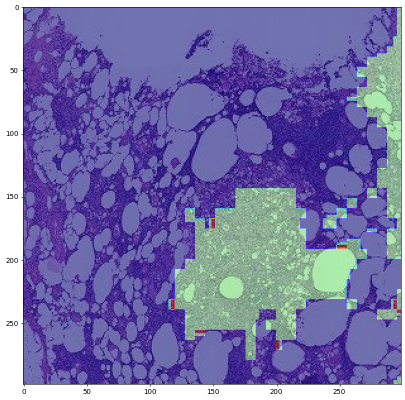

In [25]:
eg_slide_path = '/content/level5/train_image/tumor/slide075_train_image_tumor_209.jpeg'
eg_mask_path = '/content/level5/train_mask/tumor/slide075_train_mask_tumor_209.jpeg'
slide_img = load_image(eg_slide_path)
mask_img = load_image(eg_mask_path)
# show(img)

plt.figure(figsize=(10,10), dpi=50)
plt.imshow(slide_img)
# plt.figure()
plt.imshow(mask_img, cmap='jet', alpha=0.5) # Red regions contains cancer.

## Generate patches at level 4

In [60]:
# make level 4
level = 4
base_path = '/content/'

(train_image_dir, train_mask_dir, val_image_dir, val_mask_dir, test_image_dir, test_mask_dir, 
 train_image_dir_normal, train_mask_dir_normal, train_image_dir_tumor, train_mask_dir_tumor,
 val_image_dir_normal, val_mask_dir_normal, val_image_dir_tumor, val_mask_dir_tumor,
 test_image_dir_normal, test_mask_dir_normal, test_image_dir_tumor, test_mask_dir_tumor) = make_dir(base_path, level)

print('Start creating patches for train data...')
train_df4 = create_train_df(data_path, train_code, level)
print('Start creating patches for validation data...')
val_df4 = create_val_df(data_path, val_code, level)
print('Start creating patches for test data...')
test_df4 = create_test_df(data_path, test_code, level)
print('End')

In [28]:
print(sum(train_df4.Labels==1),sum(train_df4.Labels==0))
train_df4.head()

782 6172


,Image Paths,Mask Paths,Xoffset,Yoffset,Labels,slide code,level
0,/content/level4/train_image/normal/slide081_tr...,/content/level4/train_mask/normal/slide081_tra...,512,768,0,081,4
1,/content/level4/train_image/normal/slide081_tr...,/content/level4/train_mask/normal/slide081_tra...,512,896,0,081,4
2,/content/level4/train_image/normal/slide081_tr...,/content/level4/train_mask/normal/slide081_tra...,512,1024,0,081,4
3,/content/level4/train_image/normal/slide081_tr...,/content/level4/train_mask/normal/slide081_tra...,512,1152,0,081,4
4,/content/level4/train_image/normal/slide081_tr...,/content/level4/train_mask/normal/slide081_tra...,512,1280,0,081,4


In [29]:
print(sum(val_df4.Labels==1),sum(val_df4.Labels==0))
val_df4.head()

38 1540


,Image Paths,Mask Paths,Xoffset,Yoffset,Labels,slide code,level
0,/content/level4/val_image/normal/slide059_val_...,/content/level4/val_mask/normal/slide059_val_m...,1408,6528,0,059,4
1,/content/level4/val_image/normal/slide059_val_...,/content/level4/val_mask/normal/slide059_val_m...,1408,6656,0,059,4
2,/content/level4/val_image/normal/slide059_val_...,/content/level4/val_mask/normal/slide059_val_m...,1536,6528,0,059,4
3,/content/level4/val_image/normal/slide059_val_...,/content/level4/val_mask/normal/slide059_val_m...,1536,6656,0,059,4
4,/content/level4/val_image/normal/slide059_val_...,/content/level4/val_mask/normal/slide059_val_m...,1792,7936,0,059,4


In [30]:
print(sum(test_df4.Labels==1),sum(test_df4.Labels==0))
test_df4.head()

501 840


,Image Paths,Mask Paths,Xoffset,Yoffset,Labels,slide code,level
0,/content/level4/test_image/normal/slide016_tes...,/content/level4/test_mask/normal/slide016_test...,1408,9600,0,016,4
1,/content/level4/test_image/normal/slide016_tes...,/content/level4/test_mask/normal/slide016_test...,1408,9728,0,016,4
2,/content/level4/test_image/normal/slide016_tes...,/content/level4/test_mask/normal/slide016_test...,1408,9856,0,016,4
3,/content/level4/test_image/normal/slide016_tes...,/content/level4/test_mask/normal/slide016_test...,1408,9984,0,016,4
4,/content/level4/test_image/normal/slide016_tes...,/content/level4/test_mask/normal/slide016_test...,1536,9472,0,016,4


In [32]:
train_df4.to_csv(f'/content/level{level}_train_data.txt', header=None, index=None, sep=',', mode='a')
val_df4.to_csv(f'/content/level{level}_val_data.txt', header=None, index=None, sep=',', mode='a')
test_df4.to_csv(f'/content/level{level}_test_data.txt', header=None, index=None, sep=',', mode='a')

In [62]:
import shutil
shutil.make_archive(train_image_dir, 'zip', train_image_dir)
shutil.make_archive(train_mask_dir, 'zip', train_mask_dir)

shutil.make_archive(val_image_dir, 'zip', val_image_dir)
shutil.make_archive(val_mask_dir, 'zip', val_mask_dir)

shutil.make_archive(test_image_dir, 'zip', test_image_dir)
shutil.make_archive(test_mask_dir, 'zip', test_mask_dir)

'/content/level4/test_mask.zip'

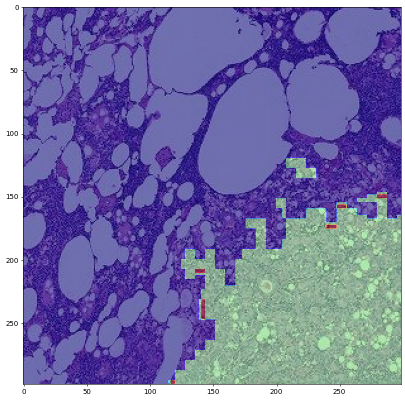

In [33]:
eg_slide_path = '/content/level4/train_image/tumor/slide075_train_image_tumor_697.jpeg'
eg_mask_path = '/content/level4/train_mask/tumor/slide075_train_mask_tumor_697.jpeg'
slide_img = load_image(eg_slide_path)
mask_img = load_image(eg_mask_path)
# show(img)

plt.figure(figsize=(10,10), dpi=50)
plt.imshow(slide_img)
# plt.figure()
plt.imshow(mask_img, cmap='jet', alpha=0.5) # Red regions contains cancer.

# Generate patches at level 3

In [34]:
# make level 4
level = 3
base_path = '/content/'

(train_image_dir, train_mask_dir, val_image_dir, val_mask_dir, test_image_dir, test_mask_dir, 
 train_image_dir_normal, train_mask_dir_normal, train_image_dir_tumor, train_mask_dir_tumor,
 val_image_dir_normal, val_mask_dir_normal, val_image_dir_tumor, val_mask_dir_tumor,
 test_image_dir_normal, test_mask_dir_normal, test_image_dir_tumor, test_mask_dir_tumor) = make_dir(base_path, level)

print('Start creating patches for train data...')
train_df3 = create_train_df(data_path, train_code, level)
print('Start creating patches for validation data...')
val_df3 = create_val_df(data_path, val_code, level)
print('Start creating patches for test data...')
test_df3 = create_test_df(data_path, test_code, level)
print('End')

Start creating patches for train data...
081 end
075 end
078 end
057 end
091 end
001 end
101 end
035 end
096 end
064 end
019 end
002 end
084 end
005 end
012 end
Start creating patches for validation data...
059 end
023 end
094 end
Start creating patches for test data...
016 end
031 end
110 end
End


In [35]:
print(sum(train_df3.Labels==1),sum(train_df3.Labels==0))
train_df3.head()

2363 23397


,Image Paths,Mask Paths,Xoffset,Yoffset,Labels,slide code,level
0,/content/level3/train_image/normal/slide081_tr...,/content/level3/train_mask/normal/slide081_tra...,1152,2304,0,081,3
1,/content/level3/train_image/normal/slide081_tr...,/content/level3/train_mask/normal/slide081_tra...,1152,2432,0,081,3
2,/content/level3/train_image/normal/slide081_tr...,/content/level3/train_mask/normal/slide081_tra...,1152,2560,0,081,3
3,/content/level3/train_image/normal/slide081_tr...,/content/level3/train_mask/normal/slide081_tra...,1152,2688,0,081,3
4,/content/level3/train_image/normal/slide081_tr...,/content/level3/train_mask/normal/slide081_tra...,1152,6656,0,081,3


In [36]:
print(sum(val_df3.Labels==1),sum(val_df3.Labels==0))
val_df3.head()

102 5753


,Image Paths,Mask Paths,Xoffset,Yoffset,Labels,slide code,level
0,/content/level3/val_image/normal/slide059_val_...,/content/level3/val_mask/normal/slide059_val_m...,2944,12928,0,059,3
1,/content/level3/val_image/normal/slide059_val_...,/content/level3/val_mask/normal/slide059_val_m...,2944,13056,0,059,3
2,/content/level3/val_image/normal/slide059_val_...,/content/level3/val_mask/normal/slide059_val_m...,2944,13440,0,059,3
3,/content/level3/val_image/normal/slide059_val_...,/content/level3/val_mask/normal/slide059_val_m...,3072,12800,0,059,3
4,/content/level3/val_image/normal/slide059_val_...,/content/level3/val_mask/normal/slide059_val_m...,3072,12928,0,059,3


In [37]:
print(sum(test_df3.Labels==1),sum(test_df3.Labels==0))
test_df3.head()

1728 3342


,Image Paths,Mask Paths,Xoffset,Yoffset,Labels,slide code,level
0,/content/level3/test_image/normal/slide016_tes...,/content/level3/test_mask/normal/slide016_test...,2944,19456,0,016,3
1,/content/level3/test_image/normal/slide016_tes...,/content/level3/test_mask/normal/slide016_test...,2944,19584,0,016,3
2,/content/level3/test_image/normal/slide016_tes...,/content/level3/test_mask/normal/slide016_test...,2944,19712,0,016,3
3,/content/level3/test_image/normal/slide016_tes...,/content/level3/test_mask/normal/slide016_test...,2944,19840,0,016,3
4,/content/level3/test_image/normal/slide016_tes...,/content/level3/test_mask/normal/slide016_test...,2944,19968,0,016,3


In [38]:
train_df3.to_csv(f'/content/level{level}_train_data.txt', header=None, index=None, sep=',', mode='a')
val_df3.to_csv(f'/content/level{level}_val_data.txt', header=None, index=None, sep=',', mode='a')
test_df3.to_csv(f'/content/level{level}_test_data.txt', header=None, index=None, sep=',', mode='a')

In [40]:
import shutil
shutil.make_archive(train_image_dir, 'zip', train_image_dir)
shutil.make_archive(train_mask_dir, 'zip', train_mask_dir)

shutil.make_archive(val_image_dir, 'zip', val_image_dir)
shutil.make_archive(val_mask_dir, 'zip', val_mask_dir)

shutil.make_archive(test_image_dir, 'zip', test_image_dir)
shutil.make_archive(test_mask_dir, 'zip', test_mask_dir)

'/content/level3/test_mask.zip'

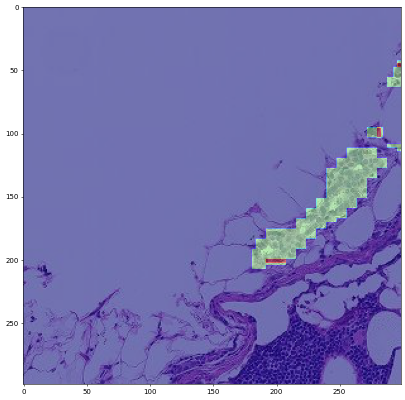

In [41]:
eg_slide_path = '/content/level3/train_image/tumor/slide075_train_image_tumor_2763.jpeg'
eg_mask_path = '/content/level3/train_mask/tumor/slide075_train_mask_tumor_2763.jpeg'
slide_img = load_image(eg_slide_path)
mask_img = load_image(eg_mask_path)
# show(img)

plt.figure(figsize=(10,10), dpi=50)
plt.imshow(slide_img)
# plt.figure()
plt.imshow(mask_img, cmap='jet', alpha=0.5)

# Reconstruct Heapmap From Patches

In [51]:
level = 3
slide_path = data_path + 'tumor_075.tif'
tumor_mask_path = data_path + 'tumor_075_mask.tif'
slide_sample = open_slide(slide_path)
tumor_mask_sample = open_slide(tumor_mask_path)

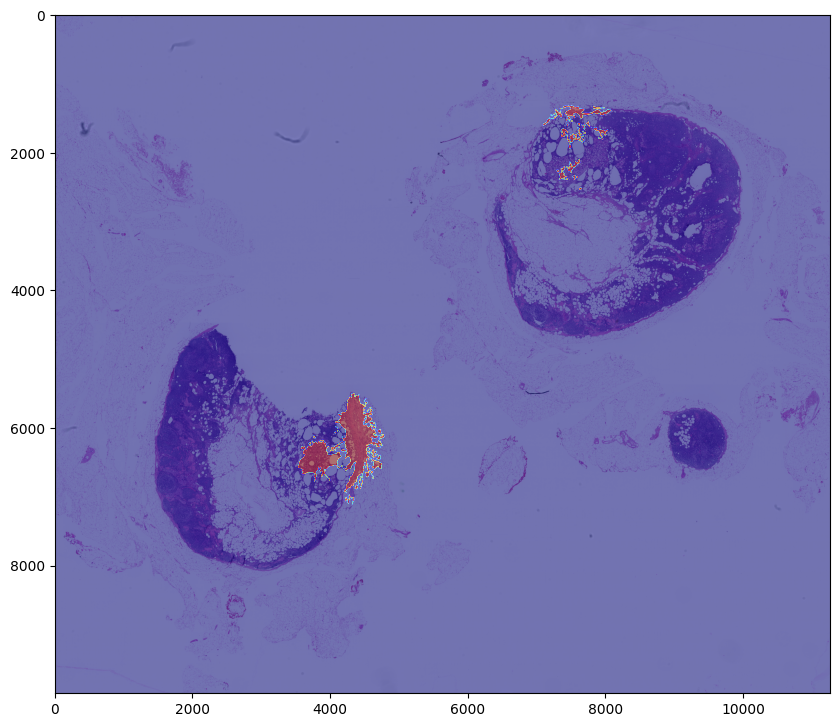

In [54]:
slide_image = read_slide(slide_sample, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide_sample.level_dimensions[level][0], 
                         height=slide_sample.level_dimensions[level][1])
mask_image = read_slide(tumor_mask_sample, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=tumor_mask_sample.level_dimensions[level][0], 
                        height=tumor_mask_sample.level_dimensions[level][1])
mask_image = mask_image[:,:,0]
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5)

In [55]:
base_name = '/content/level%s/train_image/tumor/slide075_train_image_tumor'%str(level)
train_df = pd.read_csv('/content/level%s_train_data.txt' %str(level), header=None)
train_df.columns = ['Image Paths','Mask Paths', 'Xoffset','Yoffset','Labels','level','slide code']

In [56]:
indices = np.array([i for i in range(train_df.shape[0]) if base_name in train_df['Image Paths'][i] and train_df.Labels[i]==1])
have_tumor = train_df.iloc[indices,:]

In [57]:
img = Image.new('RGB', slide_sample.level_dimensions[level])
patches_paths = have_tumor['Image Paths'].to_list()
mask_paths = have_tumor['Mask Paths'].to_list()
offsets = zip(have_tumor.Xoffset.to_list(), have_tumor.Yoffset.to_list())

for patch_path, mask_path, offset in zip(patches_paths, mask_paths, offsets):
    patch = Image.open(patch_path)
    patch = Image.blend(patch.convert("RGBA"), Image.new("RGBA", (299, 299)), 0.5)
    img.paste(patch, box=offset)
    mask = Image.open(mask_path)
    mask = Image.blend(patch.convert("RGBA"),Image.new("RGBA", (299, 299), (192, 192, 192, 3)), 0.5)
    img.paste(mask, box=offset)

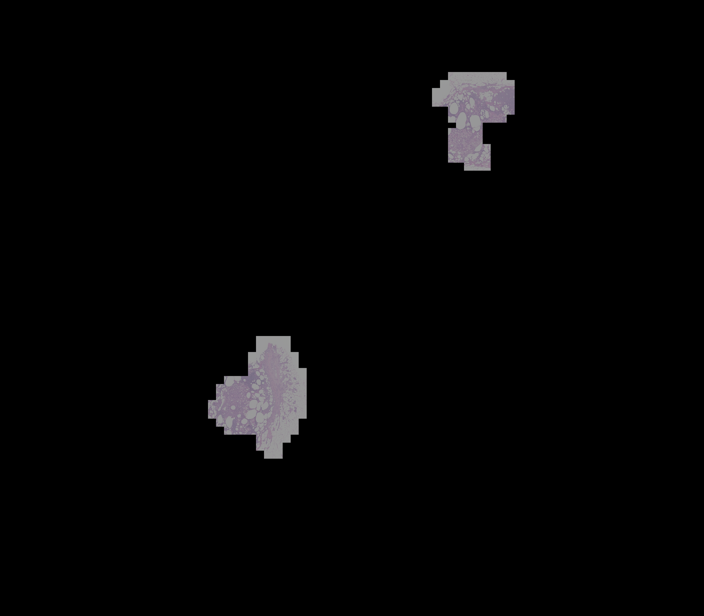

In [58]:
img.resize(map(lambda x: int(x / 16), img.size))